### Playing around with pump vibration data

In [1]:
import logging
import threading
import itertools
import math
import datetime
import pandas as pd  
import numpy as np  
import scipy as sp
import json
import ibm_db

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance

import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn import ensemble
from sklearn import linear_model
from sklearn import model_selection
from sklearn.neighbors import (KernelDensity, LocalOutlierFactor, NearestNeighbors, kneighbors_graph)
from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.mixture import BayesianGaussianMixture
from sklearn.preprocessing import (StandardScaler, RobustScaler, MinMaxScaler,
                                   minmax_scale, PolynomialFeatures)
from sklearn.covariance import MinCovDet
from sklearn.utils import check_array



from pandas.plotting import register_matplotlib_converters
import seaborn as sns
register_matplotlib_converters()

logger = logging.getLogger(__name__)

In [2]:
# read data
filename = "./data/IOT_SHADOW_PUMP_DE_GEN5_202102231533.csv.bz2" # Pump 04714B601096
#filename = "./data/IOT_SHADOW_PUMP_DE_GEN5_202202161319.csv.bz2" # Pump 04714B603408
#filename = "./data/IOT_SHADOW_PUMP_DE_GEN5_202202161408.csv.bz2" # Pump 04714B606390
##filename = "./data/IOT_SHADOW_PUMP_DE_GEN5_202202171340.csv.bz2" # Pump 04714B6037F8 good case
#filename = "./data/IOT_SHADOW_PUMP_DE_GEN5_202202171348.csv.bz2" # Pump 04714B60382B
#filename = "./data/IOT_SHADOW_PUMP_DE_GEN5_202202171815.csv.bz2" # Pump 04714FEF0005 very boring, off most of the time
#filename = "./data/IOT_SHADOW_PUMP_DE_GEN5_202202171827.csv.bz2" # Pump 04714B6036B1
#filename = "./data/IOT_SHADOW_PUMP_DE_GEN5_202202171835.csv.bz2" # Pump 04714B605699
#filename = "./data/IOT_SHADOW_PUMP_DE_GEN5_202202171840.csv.bz2" # Pump 04714B60553A
#filename = "./data/IOT_SHADOW_PUMP_DE_GEN5_202202171847.csv.bz2" # Pump 04714B60205C
#filename = "./data/IOT_SHADOW_PUMP_DE_GEN5_202202171848.csv.bz2" # Pump 04714B6029FF
#filename = "./data/IOT_SHADOW_PUMP_DE_GEN5_202202171852.csv.bz2" # Pump 04714B604101


dff = pd.read_csv(filename, parse_dates=['EVT_TIMESTAMP'], comment='#')
dff.columns = dff.columns.str.lower() 
df_clean = dff.drop(columns=['devicetype','logicalinterface_id','eventtype','format',
                             'rcv_timestamp_utc','updated_utc']).set_index(['deviceid','evt_timestamp']).dropna()
df_clean2 = df_clean[df_clean['speed'] >= 0] 
df_clean = df_clean2[df_clean2['power'] >= 0]


In [3]:
df_clean

rms_x     rms_z     rms_y   power  \
deviceid     evt_timestamp                                                      
04714B601096 2020-07-19-10.15.05.144000  0.095934  0.059262  0.956817  1.7270   
             2020-07-19-10.15.25.144000  0.093044  0.060636  0.957341  1.7298   
             2020-07-19-10.15.45.144000  0.090586  0.062215  0.956682  1.7298   
             2020-07-19-10.19.25.165000  0.091974  0.063664  0.956705  1.7262   
             2020-07-19-10.19.45.165000  0.094407  0.061748  0.956924  1.7262   
...                                           ...       ...       ...     ...   
04714B606390 2021-02-23-10.19.45.813000  0.018351  1.022032  0.021606  0.0000   
             2021-02-23-10.20.05.813000  0.018063  1.021309  0.021091  0.0000   
             2021-02-23-10.20.25.813000  0.018158  1.022185  0.021522  0.0000   
             2021-02-23-10.24.10.322000  0.018733  1.020812  0.021202  0.0000   
             2021-02-23-10.24.30.322000  0.018419  1.021242  0.021592  0.0000   

                                          speed  
deviceid     evt_timestamp                       
04714B601096 2020-07-19-10.15.05.144000  1059.0  
             2020-07-19-10.15.25.144000  1059.0  
             2020-07-19-10.15.45.144000  1059.0  
             2020-07-19-10.19.25.165000  1059.0  
             2020-07-19-10.19.45.165000  1059.0  
...                                         ...  
04714B606390 2021-02-23-10.19.45.813000     0.0  
             2021-02-23-10.20.05.813000     0.0  
             2021-02-23-10.20.25.813000     0.0  
             2021-02-23-10.24.10.322000     0.0  
             2021-02-23-10.24.30.322000     0.0  

[861165 rows x 5 columns]

### Pumps and vibration

#### Why customers are interested in vibration ?

Vibration is an undesired side effect of pump operation in general.
Vibration causes tear and wear of moving parts, from grinding down ball-bearings to loosing tie-down bolts etc.
Vice versa wear and tear causes increase in severity.
So essentially we want to monitor vibration and get alerted if the vibration levels changes significantly. 

#### Why we need instance specific models ?

Resonance is a condition where the forced vibration frequency aligns with a structural or rotor natural frequency resulting in amplified vibration.




### Measuring vibration

#### Frequency

Frequency means the number of times that vibrating object generates a repetitive motion in 1 second.

#### Displacement

Displacement means the amplitude (distance) between the peaks of vibration.

#### Velocity

Velocity means the changing rate of displacement (D) to time

#### Acceleration

Acceleration means the changing rate of velocity(V) to time

### Derived metrics

##### Peak amplitude

<img src="./images/img_function_01.gif" height=20% width=20%>

##### Root Mean Square value

<img src="./images/img_function_02.gif" height=20% width=20%>


From https://www.imv.co.jp/e/pr/vibration_measuring/chapter03/

### Standard analysis

##### Spectral analysis

<img src="./images/img_fft2_02.gif" height=20% width=20%>

#### But ...

But we have only the root mean square as the embedded controller runs an FFT every 20 secs


So we have to go another route, let's start with


### Cube Law

It takes eight times the power to drive a centrifugal pump with double speed, so we can either use power or speed.

Let's validate it here

In [4]:
df_clean['power'].values.shape

(861165,)

In [23]:

steps = [('scaler', StandardScaler()),
         ('poly', PolynomialFeatures(degree=3)),
         ('bridge', linear_model.BayesianRidge(compute_score=True))]

pipe = Pipeline(steps)

df_train = df_clean[:740000]
df_test = df_clean[740001:]


pipe.fit(df_train['speed'].values.reshape(-1,1), df_train['power'].values)


Pipeline(steps=[('scaler', StandardScaler()),
                ('poly', PolynomialFeatures(degree=3)),
                ('bridge', BayesianRidge(compute_score=True))])

### How are we doing ?

In [24]:
# how good are we doing on the training set
pipe_score_train = pipe.score(df_train['speed'].values.reshape(-1,1), df_train['power'].values)
pipe_score_test = pipe.score(df_test['speed'].values.reshape(-1,1), df_test['power'].values)

pipe_score_train, pipe_score_test

(0.43543745142279977, 0.6295772052373029)

### Apparently that's not too bad, so let's predict

In [25]:
mean, stddev = pipe.predict(df_clean['speed'].values.reshape(-1,1), return_std=True)

Text(0, 0.5, 'unit less:\n Vibration rms_x and Power')

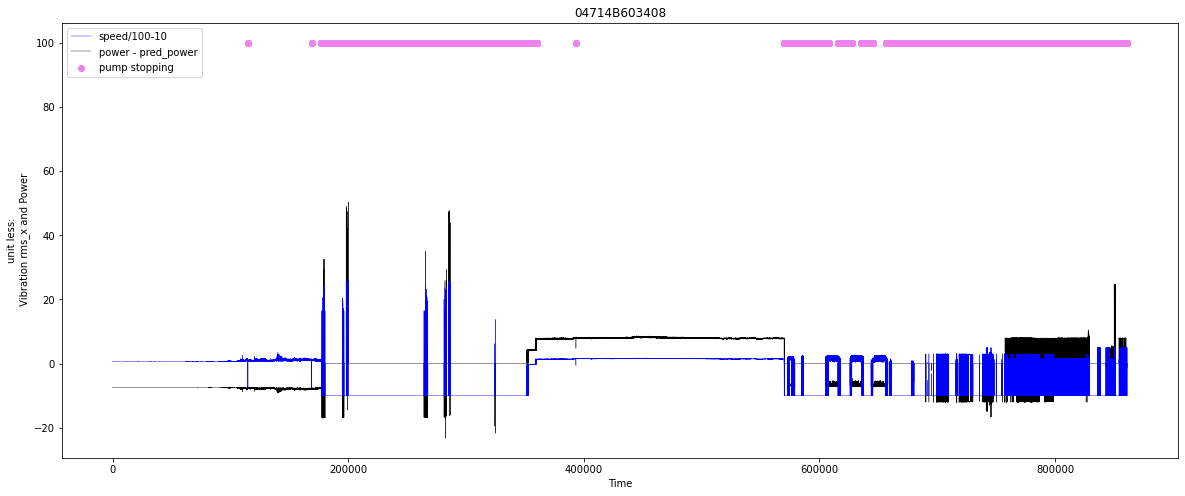

In [26]:
# this is unreadable
slow = df_clean['speed'].values.copy()
slow[slow <= 1000] = 100
slow[slow > 1000] = np.nan

fig, ax = plt.subplots(1, 1, figsize=(20, 8), squeeze=False)
i = 0
rg = range(df_clean['power'].values.size)
#ax[i,0].plot(rg, df_clean['max'] + 0.5, lw=0.4, color='blue', label='local max vib')
#ax[i,0].plot(rg, df_clean['power'], lw=0.4, color='green', label='power')
ax[i,0].plot(rg, df_clean['speed']/100-10, lw=0.4, color='blue', zorder=2, label='speed/100-10')

ax[i,0].scatter(rg, slow, lw=1, color='violet', zorder=3, label='pump stopping')

ax[i,0].plot(rg, df_clean['power'] - mean, lw=0.4, color='black', zorder=1, label='power - pred_power')
#ax[i,0].fill_between(rg, mean-stddev*2, mean+stddev*2, lw=0.05, color='orange')

ax[i,0].legend()
#ax[i,0].set_title('04714B601096')
ax[i,0].set_title('04714B603408')
ax[i,0].set_xlabel('Time')
ax[i,0].set_ylabel('unit less:\n Vibration rms_x and Power')


### Looking into vibration data itself

Text(0, 0.5, 'unit less:\n Vibration rms_x and Power')

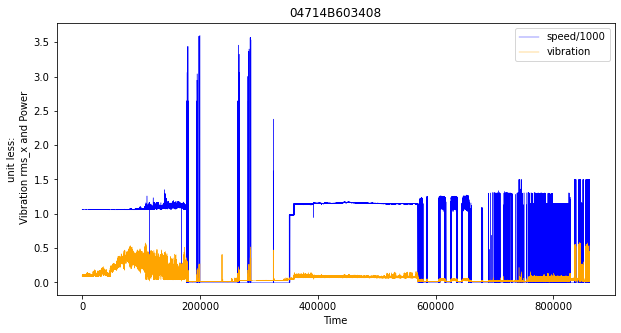

In [27]:
df_i = df_clean.reset_index().set_index('deviceid')

fig, ax = plt.subplots(1, 1, figsize=(10, 5), squeeze=False)
i = 0
rg = range(df_i['power'].values.size)
#ax[i,0].plot(rg, df_i['max'] + 0.5, lw=0.4, color='blue', label='local max vib')
#ax[i,0].plot(rg, df_i['power'], lw=0.4, color='green', label='power')
ax[i,0].plot(rg, df_i['speed']/1000, lw=0.4, color='blue', label='speed/1000')

ax[i,0].plot(rg, df_i['rms_x'], lw=0.4, color='orange', label='vibration')
ax[i,0].legend()
ax[i,0].set_title('04714B603408')

ax[i,0].set_xlabel('Time')
ax[i,0].set_ylabel('unit less:\n Vibration rms_x and Power')


### Next steps

#### Could we predict vibration of (rotor) speed ?

From the graph it doesn't look plausible. I have tried expecting to fail and actually failed ;-)

#### What have we tried instead ?

Because of resonance effects we expected to see vibration patterns depending on impeller speed. Since we're only interested in outliers we look for low density areas of vibration w.r.t speed.
We applied bivariate kernel density estimates, found out that this is quite CPU intensive and looked for a more light-weight approximation


### Looking into the joint distribution of vibration and speed

excluding "pump switched off" scenarios with speed slower than 1000

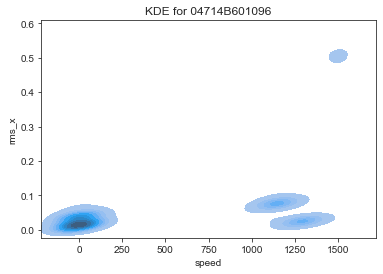

In [28]:
# display KDE - and make sure just to take a subset !
#df_display = df_clean[df_clean['speed'] > 1000]
df_display = df_clean[700000:]

sns.set_style('ticks')
#fig, ax = plt.subplots(1,1,figsize=(20,8))
#gx = sns.displot(df_display[['speed','rms_x']], x='speed', y='rms_x', kind="kde", 
#                 rug=False, height=6, aspect=2)
gx = sns.kdeplot(data = df_display, x='speed', y='rms_x', fill=True, palette="crest")
    
gx.title.set_text('KDE for ' + df_clean.index.levels[0].values[0])

### Estimate and evaluate the density

of vibration w.r.t. speed

In [33]:
xy = np.vstack([df_clean['speed'].values, df_clean['rms_x'].values]).T
#plt.scatter(xy[:,0], xy[:,1], s=40, cmap='viridis');

### First approach: apply KDE

to find global outliers

In [31]:
# run with the full set at your peril - it will take many hours
'''
df_display = df_clean[800000:].copy()

from statsmodels.nonparametric.kernel_density import KDEMultivariate

xy2 = np.hstack([df_clean['speed'].values, df_clean['rms_x'].values])

kde_model = KDEMultivariate(xy2, var_type="c") # * (len(xy[:,0]) + len(xy[:,1])))

pred_kde = kde_model.pdf(xy2).reshape(-1,1)
'''

'\ndf_display = df_clean[800000:].copy()\n\nfrom statsmodels.nonparametric.kernel_density import KDEMultivariate\n\nxy2 = np.hstack([df_clean[\'speed\'].values, df_clean[\'rms_x\'].values])\n\nkde_model = KDEMultivariate(xy2, var_type="c") # * (len(xy[:,0]) + len(xy[:,1])))\n\npred_kde = kde_model.pdf(xy2).reshape(-1,1)\n'

### Second approach: variable bandwidth KDE 

#### Apply a convolution like scheme

Use a Gaussian like kernel (N = dimension)

$$
    f_i(x) = \frac{\zeta_i^N}{\pi} \exp^{- \frac{(x-x_i)^2}{\zeta^N}}
$$
    
    and sort of a variable bandwidth estimator
    using the KNN results as local density approximation
    
$$       
    \zeta_i = \frac{\gamma}{(1 + d_i)^N}
$$
    Then define
$$
    Z(x) = \sum_i f_i(x)  \approx \int_{I} f_i(x) dI
$$
    and use a normalizer
$$
    T = \alpha \max_{i}(Z(x_i))
$$
as anomaly score threshold

For a reference the following wikipedia article about [Variable KDE](https://en.wikipedia.org/wiki/Variable_kernel_density_estimation) is a good starting point, but it doesn't cover the usage of KNN approximation to the local density as input for ballooning.


In [48]:
# do not even try - takes more than 2 hours

xy2 = np.vstack([xy[0:80000],xy[800000:]])
nbrs = NearestNeighbors(n_neighbors=7, algorithm='ball_tree').fit(xy2)

In [50]:
xy2.shape

(141165, 2)

In [51]:

k = 7
dist, indices = nbrs.kneighbors(xy2)
# find distance to k-th nearest neighbor
k_distances = np.array([dist[i][k - 1] for i in range(len(dist))])


In [52]:

# Hyperparms
gamma = 1.1
alpha = 0.1
N = 2  # dimension

zeta_ = []
zett = np.zeros_like(k_distances)
for idx, d_k in np.ndenumerate(k_distances):
    zeta_i = gamma/(1 + d_k)**N
    zeta_.append(zeta_i)
    # offset variance - evaluate scaled Gaussian
    zett += zeta_i**4 * sp.stats.multivariate_normal.pdf(xy2, mean=xy2[idx,:].reshape(-1,), cov=zeta_i)

zeta = np.array(zeta_)

T = alpha * max(zett)


Text(0.5, 1.0, 'Anomalies in bright colors')

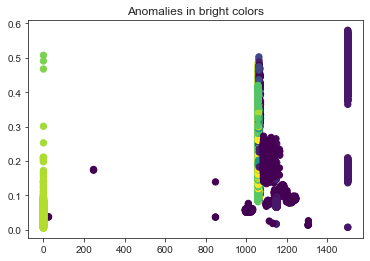

In [53]:
# show
plt.scatter(xy2[:, 0], xy2[:, 1], c=zett, s=40, cmap='viridis')
plt.title('Anomalies in bright colors')

### Approach 3: COPOD

#### Constructing the Copula

For each dimension we approximate
$$
    P(\{X_{i} < X \})
$$
with the empirical CDF for each dimension i.

This is independent of all other dimensions, so it's the marginal (e)CDF.

Since **this set of marginal CDFs uniquely determines the joint CDF**, the idea behind COPOD is to analyze the marginal CDFs.

In [57]:
### COPOD
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import gaussian_kde
from scipy.stats import skew
import skimage as ski
from skimage import util as skiutil

In [55]:
def ecdf(X):
    ecdf = ECDF(X)
    return ecdf(X)

In [60]:
#temp_win = skiutil.view_as_windows(df, window_shape=(6,), step=1)
xy.shape

(861165, 2)

In [64]:
# compute P({t < x}) and P({t < -x}) for each dimension according to the empirical CDF ()
#
left_log_univariate_cdfs = -1 * np.log(np.apply_along_axis(ecdf, 0, xy))
right_log_univariate_cdfs = -1 * np.log(np.apply_along_axis(ecdf, 0, -xy))

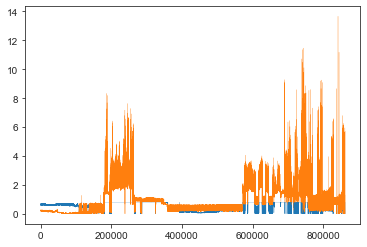

In [66]:
plt.plot(range(len(left_log_univariate_cdfs[:, 0])), left_log_univariate_cdfs[:,0], lw=0.2)
plt.plot(range(len(left_log_univariate_cdfs[:, 1])), left_log_univariate_cdfs[:,1], lw=0.2);

In [68]:
# COPOD: adjust for skewness (more weight on left or right tail) for each dimension
skewness = np.sign(skew(xy, axis=0))

# apply skewness for each dimension: either take from the right or the left tail.
U_skew = left_log_univariate_cdfs * -1 * np.sign(skewness - 1) + right_log_univariate_cdfs  * np.sign(skewness + 1)
O = np.maximum(U_skew, np.add(left_log_univariate_cdfs, right_log_univariate_cdfs) / 2)

In [69]:
# ECOD
O_ecod = np.maximum(U_skew, left_log_univariate_cdfs, right_log_univariate_cdfs)

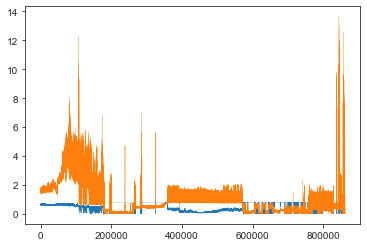

In [70]:
plt.plot(range(len(U_skew[:, 0])), U_skew[:,0], lw=0.2)
plt.plot(range(len(U_skew[:, 1])), U_skew[:,1], lw=0.2);

In [71]:
decision_score = O.sum(axis=1)
decision_score_e = O_ecod.sum(axis=1)

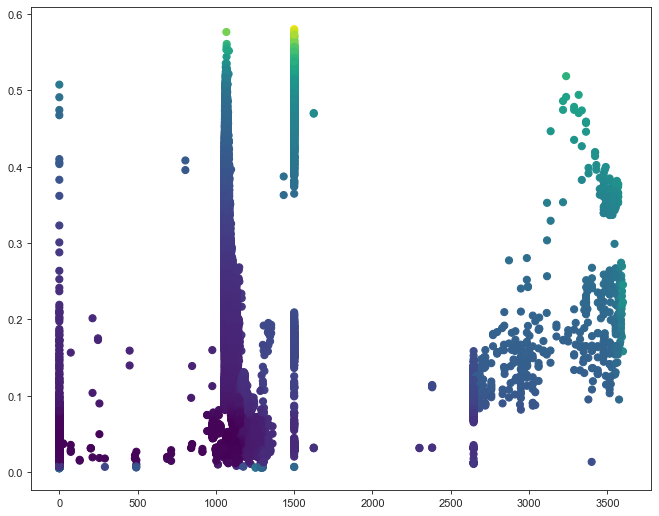

In [78]:
# outliers in 2-d
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(xy[:, 0], xy[:, 1], c=decision_score, s=40, cmap='viridis');

### Direct density approaches work well but are too expensive

for the full set and evaluating by parts doesn't yield any meaningful results


### COPOD/ECOD are quite good, but

it's hard to find a **suitable threshold**, resp. a good balance between too many false positives or negatives.

### Alternative approach

Neither KDE evaluation nor variable bandwidth estimators can be evaluated in suitable time 

So we try to approximate it with 

$$
   p(Vib | Speed) = \mathcal{N}_{M(Speed), S(Speed))}
$$

where M and S are "mildly" non-linear functions

### Choosing the non-linearity

According to the article [On the Number of Linear Regions of Deep Neural Networks](https://arxiv.org/pdf/1402.1869.pdf) a shallow network for n0-dimensional input and n1 units can cover

$$
    \sum_{j}^{n_0} \binom{n_1}{j}
$$

regions. The following figure depicts this for bivariate input

<img src="images/linear_regions.png" height=40% width=40%>


In our case with one-dimensional input this degenerates to (n_1 + 1) intervals. Hence it would be advisable to spend a second layer at least.

The following paper [Bounding and Counting Linear Regions of Deep Neural Networks](https://arxiv.org/pdf/1711.02114.pdf) develops a tighter bound for deep networks at

$$
     \sum_{(j_0, ... , j_m) \in \mathbb{E}} \prod \binom{n_l}{j_l}
$$

L is the number of Layers, n_l number of rectifiable units in Layer l, input of dimension n0.

For one-dimensional input and with all hidden layers at the same width n the bound is in the order of n^(L) intervals (for the "pieces' of the approximating piecewise linear function).


In [27]:
import torch
import torch.autograd
import torch.nn as nn

#######################################################################################
# Variational Autoencoder
#   to approximate probability distribution of targets with respect to features
#######################################################################################
# from https://www.ritchievink.com/blog/2019/09/16/variational-inference-from-scratch/
#   usual ELBO with standard prior N(0,1), standard reparametrization

# helper function
def ll_gaussian(y, mu, log_var):
    sigma = torch.exp(0.5 * log_var)
    return -0.5 * torch.log(2 * np.pi * sigma**2) - (1 / (2 * sigma**2)) * (y-mu)**2


def l_gaussian(y, mu, log_var):
    sigma = torch.exp(0.5 * log_var)
    return 1/torch.sqrt(2 * np.pi * sigma**2) / torch.exp((1 / (2 * sigma**2)) * (y-mu)**2)

class VI(nn.Module):
    def __init__(self, scaler, prior_mu=0.0, prior_sigma=1.0, beta=1.0, adjust_mean=0.0, version=None):
        self.prior_mu = prior_mu
        self.prior_sigma = prior_sigma
        self.beta = beta
        self.onnx_session = None
        self.version = version
        self.build_time = pd.Timestamp.now()
        self.scaler = scaler
        self.show_once = True
        self.adjust_mean = adjust_mean
        super().__init__()

        self.q_mu = nn.Sequential(
            nn.Linear(1, 20),    # mean  ~(20*10) regions
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

        self.q_log_var = nn.Sequential(
            nn.Linear(1, 50),    # one layer more for sigma  ~(50*35*10) regions
            nn.ReLU(),
            nn.Linear(50, 35),
            nn.ReLU(),
            nn.Linear(35, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    # draw from N(mu, sigma)
    def reparameterize(self, mu, log_var):
        # std can not be negative, thats why we use log variance
        sigma = torch.add(torch.exp(0.5 * log_var), 1e-7)
        eps = torch.randn_like(sigma)
        return mu + sigma * eps

    # sample from the one-dimensional normal distribution N(mu, exp(log_var))
    def forward(self, x):
        mu = self.q_mu(x)
        log_var = self.q_log_var(x)
        return self.reparameterize(mu, log_var), mu, log_var



### Standard loss function 

$$
    log(p(x)) = \underbrace{\mathbb{E}_{q(z)} log \frac{p(z,x)}{q(z)}}_{ELBO(q(z) || p(z|x))} + KL(q(z) || p(z| x))
$$

Rewrite ELBO

$$
    ELBO(q(z) || p(z|x)) = \mathbb{E}_{q(z)} log p(x | z) + \mathbb{E}_{q(z)} (log p(z) - log(q(z)))
$$

and apply the law of large numbers

$$
    \frac{1}{M} \sum_{M} \ell_{q}(x)  + \ell_{prior}(y_{pred}) - \ell_{q}(y_{pred})
$$

In [28]:
    # see 2.3 in https://arxiv.org/pdf/1312.6114.pdf
    #
    def elbo(self, y_pred, y, mu, log_var):

        # Sample from p(x|z) by sampling from q(z|x), passing through decoder (y_pred)
        # likelihood of observing y given Variational decoder mu and sigma - reconstruction error
        log_qzCx = ll_gaussian(y, mu, log_var)

        # KL - probability of sample y_pred w.r.t. prior
        log_pz = ll_gaussian(y_pred, self.prior_mu, torch.log(torch.tensor(self.prior_sigma)))

        # KL - probability of sample y_pred w.r.t the variational likelihood
        log_pxCz = ll_gaussian(y_pred, mu, log_var)

        ## Alternatively we could compute the KL div to the gaussian prior with something like
        # KL = -0.5 * torch.sum(1 + log_var - torch.square(mu) - torch.exp(log_var)))
        if self.show_once:
            self.show_once = False
            logger.info('Cardinalities: Mu: ' + str(mu.shape) + ' Sigma: ' + str(log_var.shape) +
                        ' loglikelihood: ' + str(log_qzCx.shape) + ' KL value: ' +
                        str((log_pz - log_pxCz).mean()))

        # by taking the mean we approximate the expectation according to the law of large numbers
        return (log_qzCx + self.beta * (log_pz - log_pxCz)).mean()

VI.elbo = elbo

### Importance weight ELBO loss function 


[Domke & Sheldon](https://proceedings.neurips.cc/paper/2018/file/25db67c5657914454081c6a18e93d6dd-Paper.pdf) depart from the random variable R for any fixed q

$$
    R = \frac{p(z,x)}{q(z)} \text{  and observe that:  } p(x) = \mathbb{E}_{q} R
$$
    
Putting more weight on the mean p(x) with averaging leads to

$$
        R_{M} = \frac{1}{M} \sum R_{i} \text{  , still with: } log p(x) >= \mathbb{E}_{q} log R_{M}
$$

As a result we get 

$$
    IW{-}ELBO_{M}[q(z) | p(z,x)] = \mathbb{E}_{q_{z_{1:m}}} log \frac{1}{M} \sum_{m} \frac{p(z_{m},x)}{q(z_{m})} =
    log \frac{1}{M} + log \sum 
$$

Applying the law of large numbers we draw M samples from q to evaluate 

$$
    log \sum_{m}^{M} exp [ \ell_{q_{m}}(x)  + \ell_{prior}(y_{pred}) - \ell_{q_{m}}(y_{pred}) ] - log M
$$

and make use of the logsumexp operator to deal with potential numerical instabilities.

Lower bounds on log p(x) should be tighter using IW-ELBO

In [29]:
    # from https://arxiv.org/pdf/1509.00519.pdf
    #  and https://justin-tan.github.io/blog/2020/06/20/Intuitive-Importance-Weighted-ELBO-Bounds
    def iwelbo(self, x, y, k_samples):

        log_iw = None
        for _ in range(k_samples):

            # Encode - sample from the encoder
            #  Latent variables mean,variance: mu_enc, log_var_enc
            # y_pred: Sample from q(z|x) by passing data through encoder and reparametrizing
            y_pred, mu_enc, log_var_enc = self.forward(x)

            # there is not much of a decoder - hence we use the identity below as decoder 'stub'
            dec_mu = mu_enc
            dec_log_var = log_var_enc

            # Sample from p(x|z) by sampling from q(z|x), passing through decoder (y_pred)
            # likelihood of observing y given Variational decoder mu and sigma - reconstruction error
            log_qzCx = ll_gaussian(y, dec_mu, dec_log_var)

            # KL (well, not true for IWAE) - prior probability of y_pred w.r.t. N(0,1)
            log_pz = ll_gaussian(y_pred, self.prior_mu, torch.log(torch.tensor(self.prior_sigma)))

            # KL (well, not true for IWAE) - probability of y_pred w.r.t the decoded variational likelihood
            log_pxCz = ll_gaussian(y_pred, dec_mu, dec_log_var)

            i_sum = log_qzCx + log_pz - log_pxCz
            if log_iw is None:
                log_iw = i_sum
            else:
                log_iw = torch.cat([log_iw, i_sum], 1)

        # loss calculation
        log_iw = log_iw.reshape(-1, k_samples)

        iwelbo_ = torch.logsumexp(log_iw, dim=1) - np.log(k_samples)

        return iwelbo_.mean()

VI.iwelbo = iwelbo

In [30]:
# prepare features and target
Feat = 'speed'
Targ = 'rms_x'
learning_rate = 0.005
iwae_samples = 10

# pass it through a standard scaler and assess the mean
scaler = StandardScaler().fit(df_clean[Feat].values.reshape(-1,1))

features = scaler.transform(df_clean[Feat].values.reshape(-1,1))
targets = df_clean[Targ].values.reshape(-1,1)

xy = np.hstack([features, targets])

ind = np.lexsort((xy[:, 1], xy[:, 0]))
ind_r = np.argsort(ind)

#Input[entity] = xy[ind][:, 0]

X = torch.tensor(xy[ind][:, 0].reshape(-1, 1), dtype=torch.float)
Y = torch.tensor(xy[ind][:, 1].reshape(-1, 1), dtype=torch.float)

# start with a prior that is not too far off
adjust_mean = targets.mean()
prior_sigma = targets.std()

prior_mu = 0
#prior_sigma = 1

vi_model = VI(scaler, prior_mu=prior_mu, prior_sigma=prior_sigma,
                          beta=1, adjust_mean=adjust_mean, version=42)

optim = torch.optim.Adam(vi_model.parameters(), lr=learning_rate)

In [31]:
prior_mu, prior_sigma, targets

(0,
 0.08749181839936376,
 array([[0.095934],
        [0.093044],
        [0.090586],
        ...,
        [0.018158],
        [0.018733],
        [0.018419]]))

In [32]:
# Train the model

print(__name__)
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
loss = 0
epochs = 80

for epoch in range(epochs):
    optim.zero_grad()
    #y_pred, mu, log_var = vi_model(X)
    #elbo = -vi_model.elbo(y_pred, Y, mu, log_var)
    iwelbo = -vi_model.iwelbo(X, Y, iwae_samples)  # default is to try with 10 samples
    loss = iwelbo.item()
    if epoch % 10 == 0:
        logger.warning('Epoch: ' + str(epoch) + ' , IWAE ELBO: ' + str(loss))

    #loss.backward()
    iwelbo.backward()
    optim.step()

logger.info('Trained VAE ' + str(vi_model) + '  loss:' + str(loss))

__main__


Epoch: 0 , IWAE ELBO: 1.0525046586990356
/home/markus/.local/lib/python3.9/site-packages/torch/autograd/__init__.py:147: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:115.)
  Variable._execution_engine.run_backward(
Epoch: 10 , IWAE ELBO: 0.725642740726471
Epoch: 20 , IWAE ELBO: -0.01741657964885235
Epoch: 30 , IWAE ELBO: -0.5576612949371338
Epoch: 40 , IWAE ELBO: -0.7785815000534058
Epoch: 50 , IWAE ELBO: -0.7799289226531982
Epoch: 60 , IWAE ELBO: -0.801336407661438
Epoch: 70 , IWAE ELBO: -0.8046125173568726


In [33]:
vi_model

VI(
  (q_mu): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
  (q_log_var): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=35, bias=True)
    (3): ReLU()
    (4): Linear(in_features=35, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [34]:
quantile = 0.99
#adjust_mean = 0

# Evaluate model
with torch.no_grad():
    mu_and_log_sigma = vi_model(X)
    mue = mu_and_log_sigma[1]
    sigma = torch.exp(0.5 * mu_and_log_sigma[2]) + 1e-5
    mu = sp.stats.norm.ppf(0.5, loc=mue, scale=sigma).reshape(-1,)
    q1 = sp.stats.norm.ppf(quantile, loc=mue, scale=sigma).reshape(-1,)

predictions = (mu[ind_r] + adjust_mean).reshape(-1,1)
pred_stddev = (q1[ind_r]).reshape(-1,1)



In [35]:
mue, sigma

(tensor([[0.0170],
         [0.0170],
         [0.0170],
         ...,
         [0.1528],
         [0.1528],
         [0.1528]]),
 tensor([[0.0507],
         [0.0507],
         [0.0507],
         ...,
         [0.0589],
         [0.0589],
         [0.0589]]))

Text(0.5, 1.0, 'pump 04714B601096')

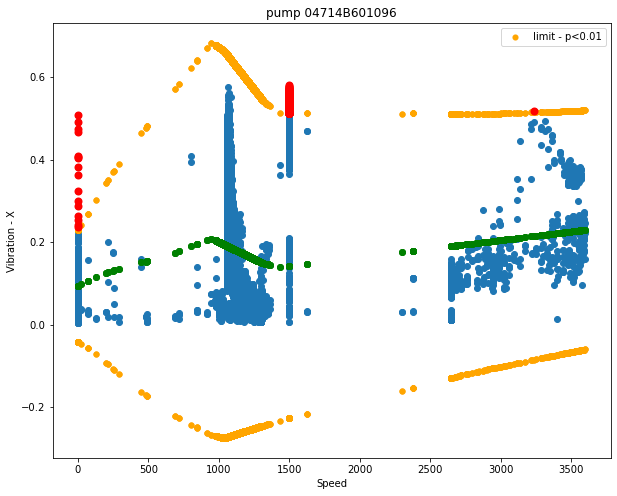

In [60]:
rmsstr = 'rms_x'
predstr = 'predicted_rms_x'
preddstr = 'pred_dev_rms_x'
anostr = 'AnomalyX'

df_i = df_clean.copy()
df_i[predstr] = predictions
df_i[preddstr] = pred_stddev

# X-coordinate
arr1 = np.where(df_i[rmsstr] > df_i[predstr] + df_i[preddstr], df_i[rmsstr], 0) + \
    np.where(df_i[rmsstr] < df_i[predstr] - df_i[preddstr], df_i[rmsstr], 0)
arr1[arr1 == 0] = np.nan
df_i[anostr] = arr1

fig, ax = plt.subplots(1, 1, figsize=(10, 8), squeeze=False)

ax[0,0].scatter(df_i['speed'], df_i[rmsstr])
ax[0,0].scatter(df_i['speed'], df_i[predstr], color='green')
ax[0,0].scatter(df_i['speed'], df_i[predstr] - df_i[preddstr], color='orange', lw=0.1, label='limit - p<0.01')
ax[0,0].scatter(df_i['speed'], df_i[predstr] + df_i[preddstr], color='orange', lw=0.1)
ax[0,0].scatter(df_i['speed'], df_i[anostr], color='red', lw=2)
ax[0,0].set_xlabel('Speed')
ax[0,0].set_ylabel('Vibration - X')
ax[0,0].legend()
ax[0,0].set_title('pump ' + df_i.index.levels[0].values[0])

### Remove false positives at low speed

Speed and Vibration are delivered by two independent sensors, and vibration tends to subside a bit later if the pump is switched off. We simply ignore outlier vibrations at low speed < 800.

In [51]:
z = np.array(np.where(df_i['speed'].values > 800)).T
z.shape

(478118, 1)

In [57]:
arr1.shape

(861165,)

Text(0, 0.5, 'unit less:\n Vibration rms_x and Power')

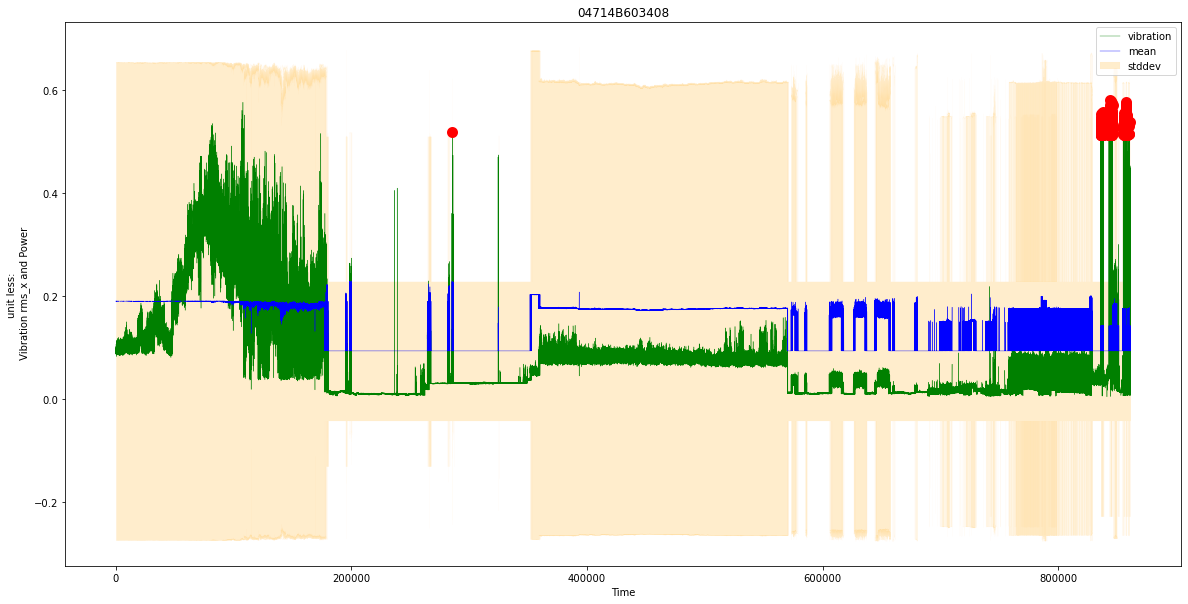

In [59]:
df_i = df_clean.reset_index().set_index('deviceid')

df_i[predstr] = predictions
df_i[preddstr] = pred_stddev

# vibration is stronger than expected and speed higher than 800
arr1 = (np.where(df_i[rmsstr] > df_i[predstr] + df_i[preddstr], df_i[rmsstr], 0) + \
    np.where(df_i[rmsstr] < df_i[predstr] - df_i[preddstr], df_i[rmsstr], 0)) * \
    (df_i['speed'].values > 800)
arr1[arr1 == 0] = np.nan
df_i[anostr] = arr1

fig, ax = plt.subplots(1, 1, figsize=(20, 10), squeeze=False)
i = 0
rg = range(df_i['speed'].values.size)
ax[i,0].plot(rg, df_i['rms_x'], lw=0.4, color='green', label='vibration')
ax[i,0].scatter(rg,df_i[anostr], lw=5, color='red', zorder=5)

ax[i,0].plot(rg, predictions, lw=0.4, color='blue', zorder=4, label='mean')
ax[i,0].fill_between(rg, (predictions-pred_stddev).flatten(),
                     (predictions + pred_stddev).flatten(),
                     lw=0.04, color='orange', zorder=2, alpha=0.2, label='stddev')

ax[i,0].legend()
ax[i,0].set_title('04714B603408')

ax[i,0].set_xlabel('Time')
ax[i,0].set_ylabel('unit less:\n Vibration rms_x and Power')